In [1]:
import psycopg2
import pandas as pd

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv('/home/data/workspace/.env')

username = os.getenv("DLK_reader_PG_USERNAME")
password = os.getenv("DLK_reader_PG_PASSWORD")
host = os.getenv("DLK_reader_PG_HOST")
port = os.getenv("DLK_reader_PG_PORT")
database = os.getenv("DLK_reader_PG_DATABASE")

In [ ]:
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=database,
    user=username,
    password=password
)

In [ ]:
cur = conn.cursor()
query = """
SELECT id, parameters::json ->> 'input_path' as input_path, deployment_id
FROM bronze.prefect_modint_prod_flow_runs
WHERE state_type = 'FAILED'
  AND created_at > '2025-11-28';
"""

In [7]:
runs_error = pd.read_sql(query, conn)
len(runs_error)

/tmp/ipykernel_771315/3096936146.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  runs_error = pd.read_sql(query, conn)


11

In [8]:
import requests
import os

API_URL = "https://modint-prefect.sia-service.kr/api"
LOG_DIR = "/home/data/workspace/modint-prefect_logs"
os.makedirs(LOG_DIR, exist_ok=True)

def download_prefect_log(flow_run_id, max_retries=3):
    save_path = os.path.join(LOG_DIR, f"{flow_run_id}.log")

    # 이미 존재하면 스킵
    if os.path.exists(save_path):
        # print(f"[SKIP] {flow_run_id} 이미 존재 → {save_path}")
        return save_path

    url = f"{API_URL}/flow_runs/{flow_run_id}/logs/download"

    for attempt in range(1, max_retries + 1):
        try:
            resp = requests.get(url, timeout=60)

            if resp.status_code == 200:
                with open(save_path, "wb") as f:
                    f.write(resp.content)
                # print(f"[OK] {flow_run_id} 저장 완료 → {save_path}")
                return save_path
            else:
                print(f"[ERROR] {flow_run_id} (시도 {attempt}/{max_retries}) "
                      f"status={resp.status_code}")

        except Exception as e:
            print(f"[EXCEPTION] {flow_run_id} (시도 {attempt}/{max_retries}) → {e}")

        # 다음 시도까지 backoff
        # time.sleep(2 * attempt)

    # print(f"[FAIL] {flow_run_id} 다운로드 실패 (총 {max_retries}회 시도)")
    return None


log_paths = []

for _, row in runs_error.iterrows():
    flow_run_id = row["id"]
    log_path = download_prefect_log(flow_run_id, max_retries=1)
    log_paths.append(log_path)

runs_error["log_path"] = log_paths

In [9]:
len(runs_error[runs_error['log_path'].notnull()]), len(runs_error[runs_error['log_path'].isnull()])

(11, 0)

In [10]:
runs_error[
    (runs_error["input_path"].isnull() | (runs_error["input_path"] == ""))
].shape[0]

1

In [11]:
runs_error[
    runs_error["log_path"].notnull() &
    (runs_error["input_path"].isnull() | (runs_error["input_path"] == ""))
].shape[0]

1

failed
    is_log
        is_input_path: 1623
        not_input_path: 112
    not_log
        is_input_path: 263
        not_input_path: 9

In [12]:
import re
import os

CLASS_PATTERN = re.compile(r'([\w\.]*?(Error|Exception))[\s:"\'\),]')
GENERIC_ERROR_WORDS = ["error", "failed", "exception", "traceback"]

def clean_error_name(err):
    if err is None:
        return None
    name = err.split(".")[-1]
    name = name.strip(' "\':,)')
    name = name.lstrip("n.N,'\"\\ ")
    if name in ["Error", "Exception"]:
        return None
    if "exited with status code: 1" in err:
        name = "ProcessExit_1"
    return name

def extract_main_error_from_log(path):
    if path is None or not os.path.exists(path):
        return None
    with open(path, "r", errors="ignore") as f:
        for line in f:
            if "exited with status code: 1" in line:
                return "ProcessExit_1"
            m = CLASS_PATTERN.search(line)
            if m:
                cleaned = clean_error_name(m.group(1))
                if cleaned:
                    return cleaned
    with open(path, "r", errors="ignore") as f:
        text = f.read().lower()
        if any(w in text for w in GENERIC_ERROR_WORDS):
            return "GenericError"
    return None

def extract_error_cluster_from_log(path, error_class=None):
    if path is None or not os.path.exists(path):
        return None

    with open(path, "r", errors="ignore") as f:
        text = f.read().lower()

    if "cuda out of memory" in text or ("out of memory" in text and "cuda" in text):
        return "CUDA_OOM"
    if "no such file" in text or "not found" in text:
        return "FILE_NOT_FOUND"
    if "is a directory" in text:
        return "IS_A_DIRECTORY"
    if "502" in text or "bad gateway" in text:
        return "HTTP_502"
    if "timeout" in text:
        return "TIMEOUT"
    if "connection" in text or "clientconnectorerror" in text:
        return "CONNECTION_ERROR"
    if "409" in text or "conflict" in text:
        return "HTTP_409"
    if "permission" in text or "denied" in text:
        return "PERMISSION_ERROR"
    if "gdal" in text or "cple_" in text:
        return "GDAL_ERROR"
    if "scheduler" in text:
        return "SCHEDULER_ERROR"
    if "valueerror" in text:
        return "VALUE_ERROR"
    if "typeerror" in text:
        return "TYPE_ERROR"
    if "attributeerror" in text:
        return "ATTRIBUTE_ERROR"
    if "keyerror" in text:
        return "KEY_ERROR"
    if "exit code" in text:
        return "PROCESS_EXIT"
    
    if error_class == "FileNotFoundError":
        return "FILE_NOT_FOUND"
    if error_class == "PrefectHTTPStatusError":
        return "HTTP_ERROR"

    return "OTHER"

In [13]:
errors = []
clusters = []

for _, row in runs_error.iterrows():
    err = extract_main_error_from_log(row["log_path"])
    errors.append(err)
runs_error["error"] = errors

for _, row in runs_error.iterrows():
    clusters.append(extract_error_cluster_from_log(row["log_path"], row["error"]))
runs_error["error_detail"] = clusters

In [14]:
missing = runs_error[runs_error['error'].isnull() & runs_error['log_path'].notnull()]
missing[['id', 'log_path']].head(20)
len(missing)

for _, row in missing.iterrows():
    with open(row['log_path'], 'r', errors='ignore') as f:
        text = f.read().lower()
    if "error" in text or "exception" in text or "traceback" in text:
        print(f"{row['id']},❗ error 문자열은 있음 → 우리의 regex가 놓친 케이스")
    else:
        print(f"{row['id']},⭕ error 문자열 자체가 없음 → 정상 로그 or 실패 정보 미기록")

In [15]:
runs_error['error'].value_counts().sum(), runs_error['error_detail'].value_counts().sum()

(11, 11)

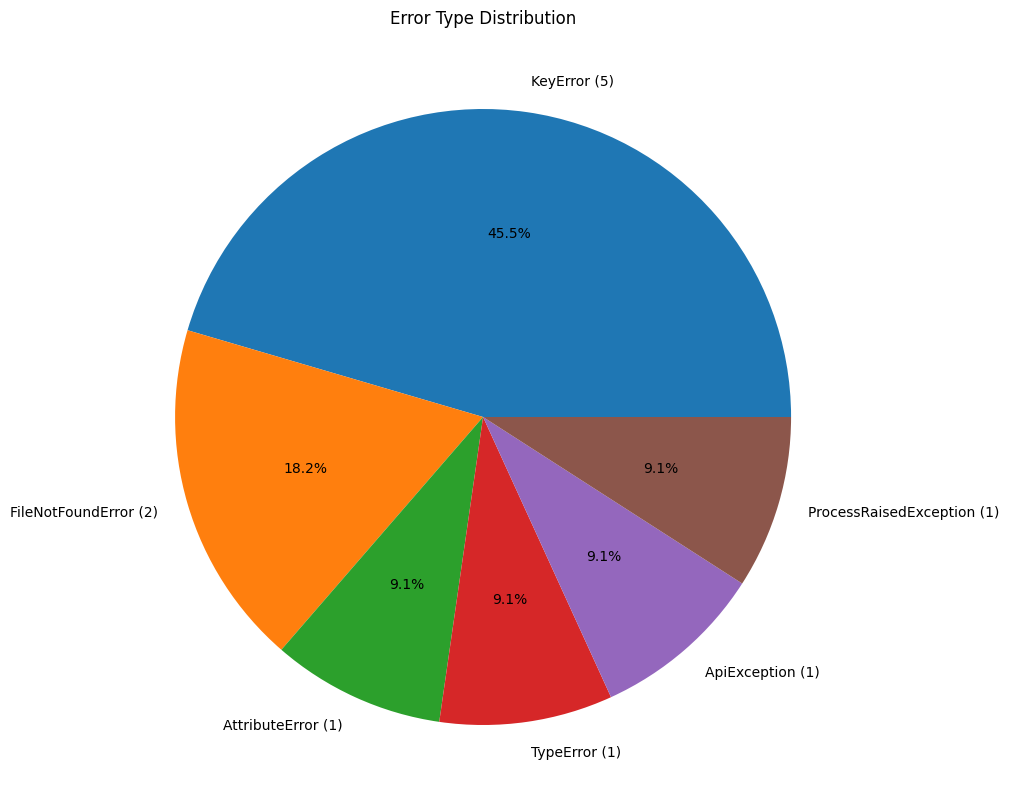

In [30]:
import matplotlib.pyplot as plt

df = runs_error['error'].value_counts().reset_index()
df.columns = ["error", "count"]

threshold = 0
large = df[df["count"] >= threshold]
small = df[df["count"] < threshold]

others_sum = small["count"].sum()
if others_sum > 0:
    large = pd.concat([large, pd.DataFrame({"error": ["Others"], "count": [others_sum]})])

# Labels include both name + count
labels = [f"{e} ({c})" for e,c in zip(large["error"], large["count"])]

plt.figure(figsize=(10,10))
plt.pie(large["count"], labels=labels, autopct="%1.1f%%")
plt.title("Error Type Distribution")
plt.show()

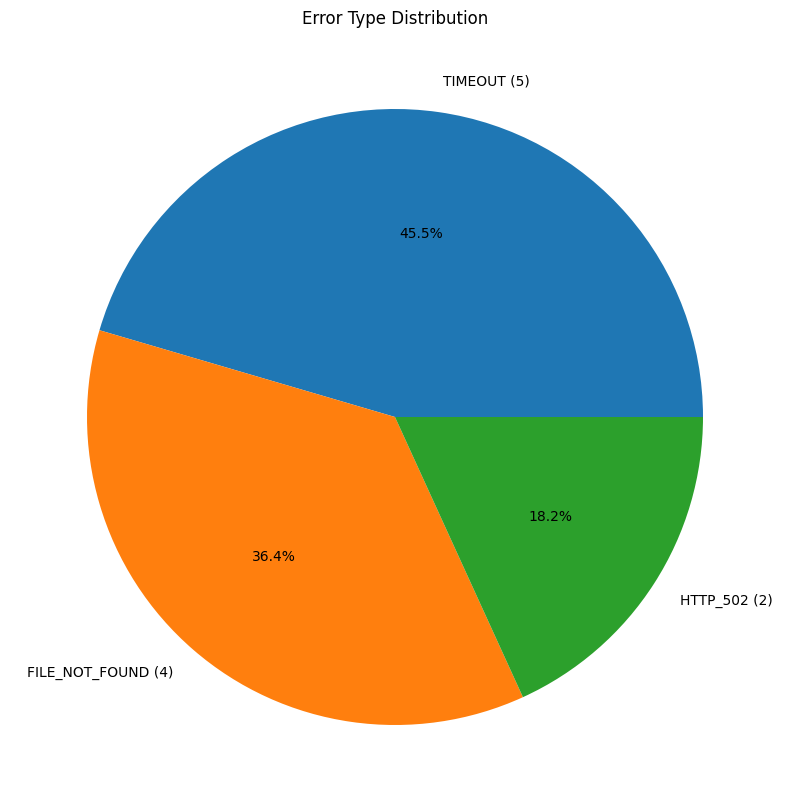

In [29]:
import matplotlib.pyplot as plt

df = runs_error['error_detail'].value_counts().reset_index()
df.columns = ["error", "count"]

threshold = 0
large = df[df["count"] >= threshold]
small = df[df["count"] < threshold]

others_sum = small["count"].sum()
if others_sum > 0:
    large = pd.concat([large, pd.DataFrame({"error": ["Others"], "count": [others_sum]})])

# Labels include both name + count
labels = [f"{e} ({c})" for e,c in zip(large["error"], large["count"])]

plt.figure(figsize=(10,10))
plt.pie(large["count"], labels=labels, autopct="%1.1f%%")
plt.title("Error Type Distribution")
plt.show()

In [33]:
runs_error['error_detail'].value_counts()

error_detail
TIMEOUT           5
FILE_NOT_FOUND    4
HTTP_502          2
Name: count, dtype: int64

In [34]:
runs_error[(runs_error["input_path"].isnull() | (runs_error["input_path"] == ""))]["error_detail"].value_counts()

error_detail
FILE_NOT_FOUND    1
Name: count, dtype: int64

In [35]:
runs_oom = runs_error[runs_error["error_detail"] == "CUDA_OOM"][["id", "input_path"]]

In [36]:
runs_error["deployment_id"].unique()[0:3]

array(['e0b1bfaf-9ec5-47ad-8d44-954d6c532666',
       'be6b793f-7b8a-4857-9187-ae50d9b65ca1',
       '9f5afa46-b36c-44a1-9397-ae7b12e9c396'], dtype=object)

In [37]:
len(runs_error["deployment_id"].unique())

6

In [ ]:
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=database,
    user=username,
    password=password
)
cur = conn.cursor()
query = """
SELECT id,
       parameters::json ->> 'input_path' AS input_path
FROM bronze.prefect_modint_prod_flow_runs
WHERE state_type = 'COMPLETED'
  AND parameters::json ->> 'input_path' IS NOT NULL
  AND parameters::json ->> 'input_path' NOT LIKE '%/'
  AND parameters::json ->> 'input_path' NOT ILIKE '%ext%'
  AND parameters::json ->> 'input_path' NOT ILIKE '%vrt%'
  AND created_at > '2025-11-28'
ORDER BY random();
"""
cur.execute(query)
rows = cur.fetchall()
runs_comp = pd.DataFrame(rows, columns=["id", "input_path"])

In [43]:
from osgeo import gdal

def get_image_size(path):
    try:
        ds = gdal.Open(path)
        return ds.RasterXSize, ds.RasterYSize
    except:
        return None, None

In [44]:
import requests

API_URL = "https://modint-prefect.sia-service.kr/api"

def get_flow_memory(flow_run_id):
    url = f"{API_URL}/flow_runs/{flow_run_id}"
    resp = requests.get(url, timeout=30)
    if resp.status_code != 200:
        return None
    
    data = resp.json()
    mem_str = data["parameters"]["flow_config"].get("memory")
    if mem_str is None:
        return None
    
    # "64Gi" → 64
    return int(mem_str.replace("Gi", ""))

In [45]:
import pandas as pd

def add_features(df):
    mem_list = []
    area_list = []

    for _, row in df.iterrows():
        mem = get_flow_memory(row["id"])
        mem_list.append(mem)

        w, h = get_image_size(row["input_path"])
        if w is None:
            area_list.append(None)
        else:
            area_list.append(w * h)

    df["memory_gi"] = mem_list
    df["area"] = area_list
    return df

runs_oom = add_features(runs_oom)
runs_comp = add_features(runs_comp)

ERROR 4: `/nas/k8s/dev/research/hojin/DSAR-TD/20251126/scene_inference/sample' not recognized as a supported file format.
ERROR 4: /nas/k8s/dev/research/minkisong/dputils/642_cog/DSARTD_20250613_144533--GEC_B_UHR_1_VV_L_cog.tif: No such file or directory
ERROR 4: /nas/k8s/dev/research/minkisong/dputils/642/DSARTD_20250616_135815--GEC_B_UHR_1_VV_L.tif: No such file or directory
Warning 1: /nas/Projects/C-BIZ01A/PacGeo/Samples/Ontario_Forestry/IMG_PHR1A_PMS_202510161608295_ORT_90718571-1309-4a29-ca66-f65d4d98447e_R1C1.TIF: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
ERROR 4: /nas/k8s/dev/research/minkisong/dputils/642/DSARTD_20250530_101102--GEC_B_UHR_1_VV_L.tif: No such file or directory
ERROR 4: /nas/Projects/C-BIZ01A/Dhruva/5m_resolution.tif: No such file or directory
ERROR 4: /nas/k8s/dev/research/minkisong/dputils/642/DSARTD_20250613_144533--GEC_B_UHR_1_VV_L.tif: No such

In [46]:
len(runs_oom["memory_gi"]) - runs_oom["memory_gi"].value_counts().sum(), len(runs_comp["memory_gi"]) - runs_comp["memory_gi"].value_counts().sum()

(0, 79)

In [47]:
runs_oom["memory_gi"].value_counts(), runs_comp["memory_gi"].value_counts()

(Series([], Name: count, dtype: int64),
 memory_gi
 64.0     52
 128.0     1
 256.0     1
 Name: count, dtype: int64)

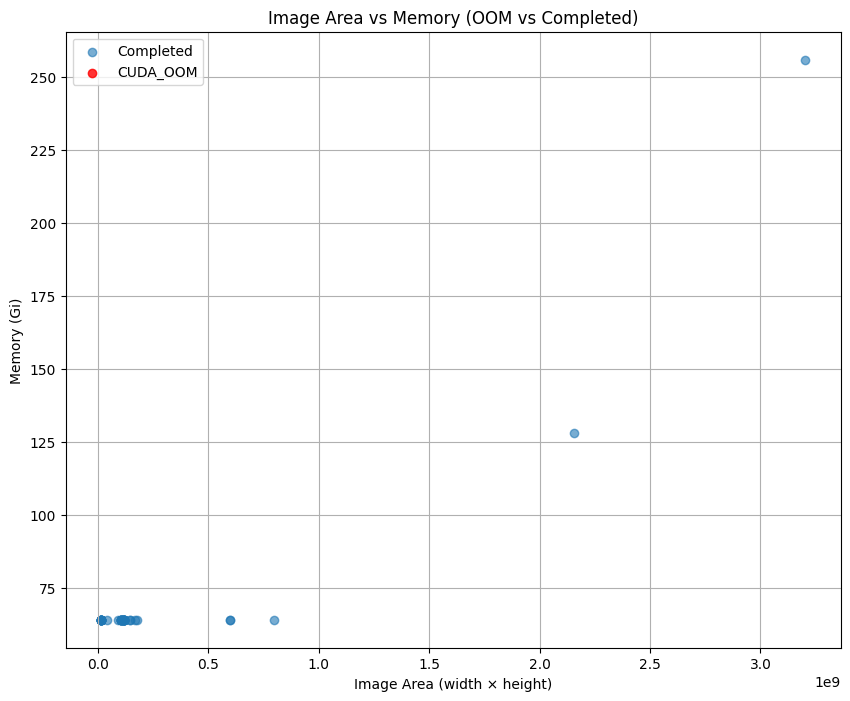

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(
    runs_comp["area"], runs_comp["memory_gi"],
    label="Completed", alpha=0.6
)

plt.scatter(
    runs_oom["area"], runs_oom["memory_gi"],
    label="CUDA_OOM", alpha=0.8, color="red"
)

plt.xlabel("Image Area (width × height)")
plt.ylabel("Memory (Gi)")
plt.title("Image Area vs Memory (OOM vs Completed)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import psycopg2
import pandas as pd

conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=database,
    user=username,
    password=password
)
cur = conn.cursor()
query = """
SELECT id,
       parameters::json ->> 'input_path' AS input_path, state_type, state_name
FROM bronze.prefect_modint_prod_flow_runs
WHERE created_at > '2025-11-28';
"""

runs = pd.read_sql(query, conn)

/tmp/ipykernel_771315/2581674151.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  runs = pd.read_sql(query, conn)


In [55]:
import os

LOG_DIR = "/home/data/workspace/modint-prefect_logs"

def read_log(flow_run_id):
    log_path = os.path.join(LOG_DIR, f"{flow_run_id}.log")
    if os.path.exists(log_path):
        return log_path
    return None

log_paths = []

for _, row in runs.iterrows():
    flow_run_id = row["id"]
    log_path = read_log(flow_run_id)
    log_paths.append(log_path)

runs["log_path"] = log_paths

In [56]:
from osgeo import gdal

def get_image_size(path):
    if not isinstance(path, str):
        return None, None
    if not os.path.exists(path):
        return None, None
    
    try:
        ds = gdal.Open(path)
        if ds is None:
            return None, None
        return ds.RasterXSize, ds.RasterYSize
    except:
        return None, None

import requests

API_URL = "https://modint-prefect.sia-service.kr/api"

def get_flow_resources(flow_run_id):
    url = f"{API_URL}/flow_runs/{flow_run_id}"
    try:
        resp = requests.get(url, timeout=30)
        if resp.status_code != 200:
            return None, None, None
        
        data = resp.json()

        params = data.get("parameters", {})
        flow_config = params.get("flow_config", {})

        mem_str = flow_config.get("memory")
        if mem_str is None:
            memory = None
        else:
            memory = int(mem_str.replace("Gi", ""))

        deployment_name = flow_config.get("prefect_deployment_name")
        work_pool_name = data.get("work_pool_name")

        return memory, deployment_name, work_pool_name

    except Exception:
        return None, None, None

In [57]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def process_row(row):
    memory, deployment_name, work_pool_name = get_flow_resources(row["id"])
    w, h = get_image_size(row["input_path"])
    area = w * h if w and h else None
    return (row["id"], memory, deployment_name, work_pool_name, area)

def parallel_extract(df, workers=8):
    ids = []
    mems = []; deploys = []; work_pools =[];
    areas = []

    rows = [row for _, row in df.iterrows()]

    with ProcessPoolExecutor(max_workers=workers) as ex:
        for result in tqdm(ex.map(process_row, rows), total=len(rows)):
            id_, mem, deploy, work_pool, area = result
            ids.append(id_)
            mems.append(mem)
            deploys.append(deploy)
            work_pools.append(work_pool)
            areas.append(area)

    df["memory_gi"] = mems
    df["deployment_name"] = deploys
    df["work_pool_name"] = work_pools
    df["area"] = areas
    return df

In [58]:
runs = parallel_extract(runs, workers=12)

100%|██████████| 312/312 [00:09<00:00, 34.58it/s]


In [59]:
runs.to_csv("/home/data/workspace/modint_prefect_failed_runs_with_logs_v2.csv", index=False)

In [60]:
import re
import os

CLASS_PATTERN = re.compile(r'([\w\.]*?(Error|Exception))[\s:"\'\),]')
GENERIC_ERROR_WORDS = ["error", "failed", "exception", "traceback"]

def clean_error_name(err):
    if err is None:
        return None
    name = err.split(".")[-1]
    name = name.strip(' "\':,)')
    name = name.lstrip("n.N,'\"\\ ")
    if name in ["Error", "Exception"]:
        return None
    if "exited with status code: 1" in err:
        name = "ProcessExit_1"
    return name

def extract_main_error_from_log(path):
    if path is None or not os.path.exists(path):
        return None
    with open(path, "r", errors="ignore") as f:
        for line in f:
            if "exited with status code: 1" in line:
                return "ProcessExit_1"
            m = CLASS_PATTERN.search(line)
            if m:
                cleaned = clean_error_name(m.group(1))
                if cleaned:
                    return cleaned
    with open(path, "r", errors="ignore") as f:
        text = f.read().lower()
        if any(w in text for w in GENERIC_ERROR_WORDS):
            return "GenericError"
    return None

def extract_error_cluster_from_log(path, error_class=None):
    if path is None or not os.path.exists(path):
        return None

    with open(path, "r", errors="ignore") as f:
        text = f.read().lower()

    if "cuda out of memory" in text or ("out of memory" in text and "cuda" in text):
        return "CUDA_OOM"
    if "no such file" in text or "not found" in text:
        return "FILE_NOT_FOUND"
    if "is a directory" in text:
        return "IS_A_DIRECTORY"
    if "502" in text or "bad gateway" in text:
        return "HTTP_502"
    if "timeout" in text:
        return "TIMEOUT"
    if "connection" in text or "clientconnectorerror" in text:
        return "CONNECTION_ERROR"
    if "409" in text or "conflict" in text:
        return "HTTP_409"
    if "permission" in text or "denied" in text:
        return "PERMISSION_ERROR"
    if "gdal" in text or "cple_" in text:
        return "GDAL_ERROR"
    if "scheduler" in text:
        return "SCHEDULER_ERROR"
    if "valueerror" in text:
        return "VALUE_ERROR"
    if "typeerror" in text:
        return "TYPE_ERROR"
    if "attributeerror" in text:
        return "ATTRIBUTE_ERROR"
    if "keyerror" in text:
        return "KEY_ERROR"
    if "exit code" in text:
        return "PROCESS_EXIT"
    
    if error_class == "FileNotFoundError":
        return "FILE_NOT_FOUND"
    if error_class == "PrefectHTTPStatusError":
        return "HTTP_ERROR"

    return "OTHER"

In [61]:
errors = []
clusters = []

for _, row in runs.iterrows():
    err = extract_main_error_from_log(row["log_path"])
    errors.append(err)
runs["error"] = errors

for _, row in runs.iterrows():
    clusters.append(extract_error_cluster_from_log(row["log_path"], row["error"]))
runs["error_cluster"] = clusters

In [62]:
runs.to_csv("/home/data/workspace/modint_prefect_failed_runs_with_logs_errors_v2.csv", index=False)

In [63]:
import pandas as pd
runs = pd.read_csv("/home/data/workspace/modint_prefect_failed_runs_with_logs_errors_v2.csv")

In [64]:
def convert_memory_label(x):
    if pd.isna(x):
        return "None"
    return f"{int(x)}Gi"

runs["memory"] = runs["memory_gi"].apply(convert_memory_label)

In [65]:
stages = [
    "memory",
    "state_type",
    "state_name",
    "error_cluster",
    "error",
    "deployment_name"
]

def encode_none(df):
    df = df.copy()
    for col in stages:
        df[col] = df[col].apply(lambda x: f"None:{col}" if pd.isna(x) else x)
    return df

In [66]:
runs_encoded = encode_none(runs)
failed = runs_encoded[runs_encoded["state_type"] == "FAILED"]
others = runs_encoded[runs_encoded["state_type"] != "FAILED"]

In [67]:
g1 = failed.groupby(["memory", "state_type"]).size().reset_index(name="count")
g2 = failed.groupby(["state_type", "state_name"]).size().reset_index(name="count")
g3 = failed.groupby(["state_name", "error_cluster"]).size().reset_index(name="count")
g4 = failed.groupby(["error_cluster", "error"]).size().reset_index(name="count")

failed_links = []
for _, row in g1.iterrows():
    failed_links.append([row["memory"], row["state_type"], row["count"]])

for _, row in g2.iterrows():
    failed_links.append([row["state_type"], row["state_name"], row["count"]])

for _, row in g3.iterrows():
    failed_links.append([row["state_name"], row["error_cluster"], row["count"]])

for _, row in g4.iterrows():
    failed_links.append([row["error_cluster"], row["error"], row["count"]])

In [68]:
s1 = others.groupby(["memory", "state_type"]).size().reset_index(name="count")
s2 = others.groupby(["state_type", "state_name"]).size().reset_index(name="count")
s3 = others.groupby(["state_name", "deployment_name"]).size().reset_index(name="count")


others_links = []
for _, row in s1.iterrows():
    others_links.append([row["memory"], row["state_type"], row["count"]])

for _, row in s2.iterrows():
    others_links.append([row["state_type"], row["state_name"], row["count"]])

for _, row in s3.iterrows():
    others_links.append([row["state_name"], row["deployment_name"], row["count"]])

In [69]:
all_links = failed_links + others_links
links_df = pd.DataFrame(all_links, columns=["source", "target", "count"])
links_df = links_df.fillna("NoError")

In [70]:
node_labels = pd.unique(links_df[["source", "target"]].values.ravel()).tolist()

# desired_order = ["FAILED", "COMPLETED"]
# current_state_nodes = [x for x in node_labels if x in desired_order]
# extra_state_nodes = [
#     x for x in node_labels
#     if x not in desired_order and x.startswith("state_type:")]

# final_state_nodes = desired_order + extra_state_nodes

# other_nodes = [x for x in node_labels if x not in final_state_nodes]
# node_labels_ordered = final_state_nodes + other_nodes

# node_index = {name: i for i, name in enumerate(node_labels_ordered)}

node_index = {name: i for i, name in enumerate(node_labels)}

sources = links_df["source"].map(node_index)
targets = links_df["target"].map(node_index)
values  = links_df["count"]

In [71]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        label=node_labels,
        line=dict(color="black", width=0.5),
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
    )
)])

fig.update_layout(
    title_text=(
        "Flow Run Alluvial Diagram<br>"
        "<sup>FAILED: memory → state_type → state_name → error_cluster → error<br>"
        "OTHERS: memory → state_type → state_name → deployment_name</sup>"
    ),
    font_size=12,
    height=900
)

fig.show()

In [72]:
import datetime
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
fig.write_html(f"/home/data/workspace/sankey_{ts}_v2.html")

In [73]:
runs.columns

Index(['id', 'input_path', 'state_type', 'state_name', 'log_path', 'memory_gi',
       'deployment_name', 'work_pool_name', 'area', 'error', 'error_cluster',
       'memory'],
      dtype='object')

In [74]:
failed = runs[runs["state_type"] == "FAILED"].copy()
succ = runs[runs["state_type"] == "COMPLETED"].copy()
failed["memory_gi"].value_counts(dropna=False), succ["memory_gi"].value_counts(dropna=False)

(memory_gi
 64.0     9
 128.0    1
 NaN      1
 Name: count, dtype: int64,
 memory_gi
 NaN      223
 64.0      53
 128.0      1
 256.0      1
 Name: count, dtype: int64)

In [75]:
failed_mean = failed["memory_gi"].mean()
succ_mean = succ["memory_gi"].mean()

failed_median = failed["memory_gi"].median()
succ_median = succ["memory_gi"].median()

print(f"Failed Memory - Mean: {failed_mean}, Median: {failed_median}")
print(f"Success Memory - Mean: {succ_mean}, Median: {succ_median}")

Failed Memory - Mean: 70.4, Median: 64.0
Success Memory - Mean: 68.65454545454546, Median: 64.0


In [76]:
failed_nan_rate = failed["memory_gi"].isna().mean()
succ_nan_rate   = succ["memory_gi"].isna().mean()
print(f"Failed Memory NaN Rate: {failed_nan_rate:.2%}")
print(f"Success Memory NaN Rate: {succ_nan_rate:.2%}")

Failed Memory NaN Rate: 9.09%
Success Memory NaN Rate: 80.22%


In [77]:
failed_corr = failed[["memory_gi", "area"]].corr()
succ_corr = succ[["memory_gi", "area"]].corr()
print("Failed Correlation:\n", failed_corr)
print("Success Correlation:\n", succ_corr)

Failed Correlation:
            memory_gi  area
memory_gi        1.0   1.0
area             1.0   1.0
Success Correlation:
            memory_gi      area
memory_gi   1.000000  0.927652
area        0.927652  1.000000


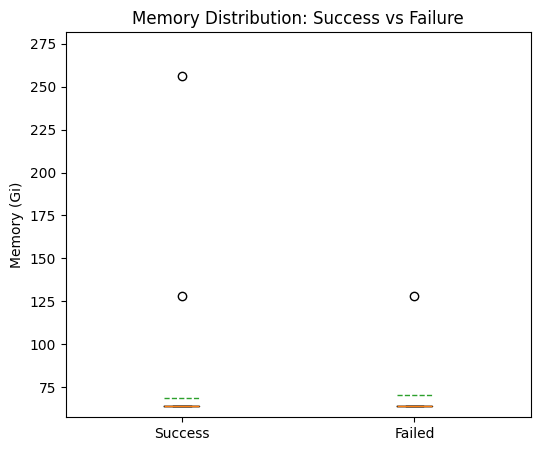

In [78]:
import matplotlib.pyplot as plt

succ_valid = succ["memory_gi"].dropna()
failed_valid = failed["memory_gi"].dropna()

plt.figure(figsize=(6,5))
plt.boxplot(
    [succ_valid, failed_valid],
    labels=["Success", "Failed"],
    showmeans=True,
    meanline=True
)

plt.ylim(min(runs["memory_gi"].dropna()) * 0.9,
         max(runs["memory_gi"].dropna()) * 1.1)

plt.ylabel("Memory (Gi)")
plt.title("Memory Distribution: Success vs Failure")
plt.show()

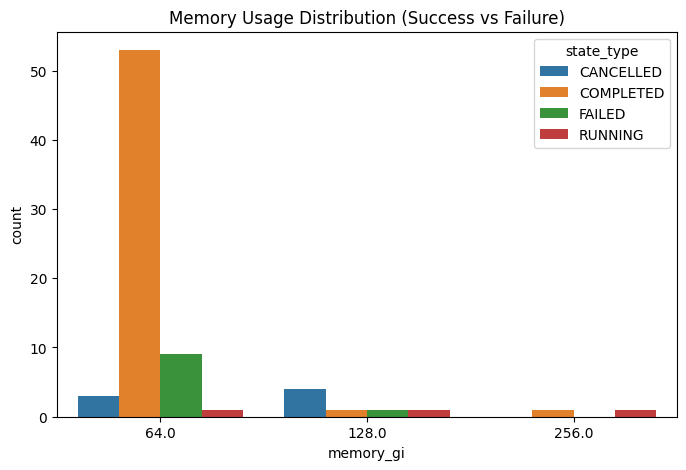

In [79]:
mem_dist = runs.groupby(["state_type", "memory_gi"]).size().reset_index(name="count")

# pip install seaborn
import seaborn as sns
plt.figure(figsize=(8,5))
sns.barplot(data=mem_dist, x="memory_gi", y="count", hue="state_type")
plt.title("Memory Usage Distribution (Success vs Failure)")
plt.show()

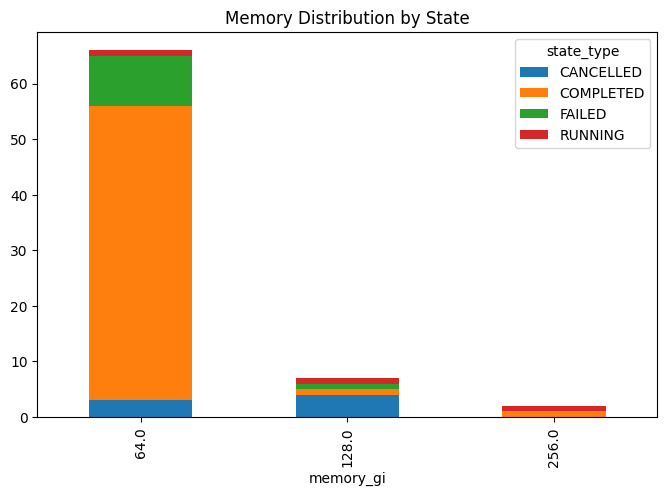

In [80]:
pivot = mem_dist.pivot(index="memory_gi", columns="state_type", values="count").fillna(0)
pivot.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Memory Distribution by State")
plt.show()

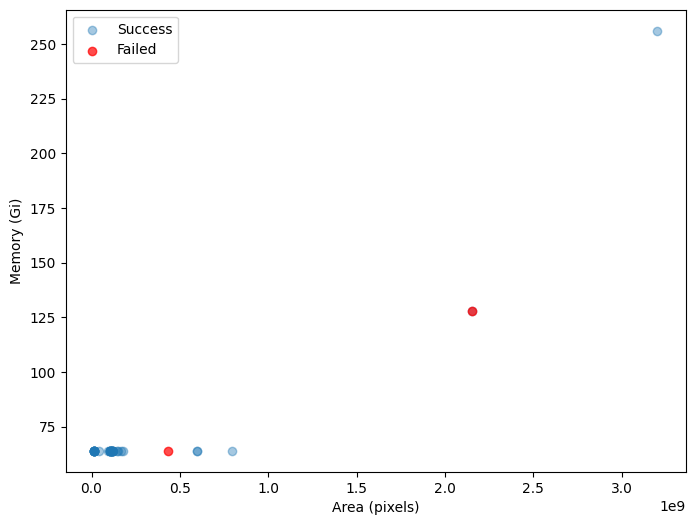

In [81]:
plt.figure(figsize=(8,6))
plt.scatter(succ["area"], succ["memory_gi"], alpha=0.4, label="Success")
plt.scatter(failed["area"], failed["memory_gi"], alpha=0.7, label="Failed", color="red")
plt.xlabel("Area (pixels)")
plt.ylabel("Memory (Gi)")
plt.legend()
plt.show()

In [82]:
risk = (
    failed["memory_gi"].value_counts() /
    (failed["memory_gi"].value_counts() + succ["memory_gi"].value_counts())
)
risk

memory_gi
64.0     0.145161
128.0    0.500000
256.0         NaN
Name: count, dtype: float64

In [83]:
import numpy as np
# area 기반 성공률 분석
runs["area_bin"] = pd.qcut(runs["area"], q=20, duplicates="drop")
runs["area_bin"] = runs["area_bin"].astype("object").replace({np.nan: None})
rate_area = (
    runs.groupby(["area_bin", "memory_gi"])["state_type"]
        .apply(lambda x: (x=="COMPLETED").mean())
        .reset_index(name="success_rate")
)
rate_area

,area_bin,memory_gi,success_rate
0,"(12911499.999, 77120104.2]",64.0,0.928571
1,"(77120104.2, 92702547.0]",64.0,1.000000
2,"(92702547.0, 103390960.4]",64.0,1.000000
3,"(103390960.4, 114573581.4]",64.0,1.000000
4,"(114573581.4, 118820503.2]",64.0,0.857143
5,"(118820503.2, 130400359.0]",64.0,1.000000
6,"(144864064.0, 145745920.0]",64.0,1.000000
7,"(145745920.0, 146940804.0]",64.0,1.000000
8,"(165789180.0, 280943083.2]",64.0,1.000000
9,"(280943083.2, 2154965072.0]",64.0,0.500000


In [84]:
rate_dep = (
    runs.groupby(["deployment_name", "memory_gi"])["state_type"]
        .apply(lambda x: (x=="COMPLETED").mean())
        .reset_index(name="success_rate")
)
rate_dep

,deployment_name,memory_gi,success_rate
0,EO-Detection-Aircraft,64.0,1.000000
1,EO-Detection-Ship,64.0,1.000000
2,EO-Segmentation-Landcover,64.0,0.333333
3,SAR-Detection-Ship,64.0,0.555556
4,SkySat-SR-4x-BGRN,64.0,0.500000
5,SkySat-SR-4x-RGBN,64.0,1.000000
6,SkySat-SR-BGR,64.0,1.000000
7,SkySat-SR-BGRN,64.0,1.000000
8,SkySat-SR-RGBN,64.0,0.947368
9,SuperX-1Ch,64.0,0.571429


In [85]:
rate_pool = (
    runs.groupby(["work_pool_name", "memory_gi"])["state_type"]
        .apply(lambda x: (x=="COMPLETED").mean())
        .reset_index(name="success_rate")
)
rate_pool

,work_pool_name,memory_gi,success_rate
0,modint-prefect-workpool-2,64.0,0.803030
1,modint-prefect-workpool-2,128.0,0.142857
2,modint-prefect-workpool-2,256.0,0.500000


In [86]:
rate_area_dep = (
    runs.groupby(["deployment_name", "area_bin", "memory_gi"])
        .state_type.apply(lambda x: (x=="COMPLETED").mean())
        .reset_index(name="success_rate")
)
rate_area_dep

,deployment_name,area_bin,memory_gi,success_rate
0,EO-Detection-Aircraft,"(144864064.0, 145745920.0]",64.0,1.00
1,EO-Detection-Ship,"(145745920.0, 146940804.0]",64.0,1.00
2,EO-Detection-Ship,"(165789180.0, 280943083.2]",64.0,1.00
3,EO-Segmentation-Landcover,"(280943083.2, 2154965072.0]",64.0,0.00
4,SkySat-SR-4x-RGBN,"(12911499.999, 77120104.2]",64.0,1.00
5,SkySat-SR-BGRN,"(77120104.2, 92702547.0]",64.0,1.00
6,SkySat-SR-BGRN,"(92702547.0, 103390960.4]",64.0,1.00
7,SkySat-SR-BGRN,"(103390960.4, 114573581.4]",64.0,1.00
8,SkySat-SR-BGRN,"(114573581.4, 118820503.2]",64.0,1.00
9,SkySat-SR-BGRN,"(118820503.2, 130400359.0]",64.0,1.00


In [87]:
rate_area_dep_pool = (
 runs.groupby(["deployment_name", "memory_gi", "area_bin", "work_pool_name"])
 ["state_type"]
 .apply(lambda x: (x=="COMPLETED").mean())
 .reset_index(name="success_rate")
)
rate_area_dep_pool

,deployment_name,memory_gi,area_bin,work_pool_name,success_rate
0,EO-Detection-Aircraft,64.0,"(144864064.0, 145745920.0]",modint-prefect-workpool-2,1.00
1,EO-Detection-Ship,64.0,"(145745920.0, 146940804.0]",modint-prefect-workpool-2,1.00
2,EO-Detection-Ship,64.0,"(165789180.0, 280943083.2]",modint-prefect-workpool-2,1.00
3,EO-Segmentation-Landcover,64.0,"(280943083.2, 2154965072.0]",modint-prefect-workpool-2,0.00
4,SkySat-SR-4x-RGBN,64.0,"(12911499.999, 77120104.2]",modint-prefect-workpool-2,1.00
5,SkySat-SR-BGRN,64.0,"(77120104.2, 92702547.0]",modint-prefect-workpool-2,1.00
6,SkySat-SR-BGRN,64.0,"(92702547.0, 103390960.4]",modint-prefect-workpool-2,1.00
7,SkySat-SR-BGRN,64.0,"(103390960.4, 114573581.4]",modint-prefect-workpool-2,1.00
8,SkySat-SR-BGRN,64.0,"(114573581.4, 118820503.2]",modint-prefect-workpool-2,1.00
9,SkySat-SR-BGRN,64.0,"(118820503.2, 130400359.0]",modint-prefect-workpool-2,1.00


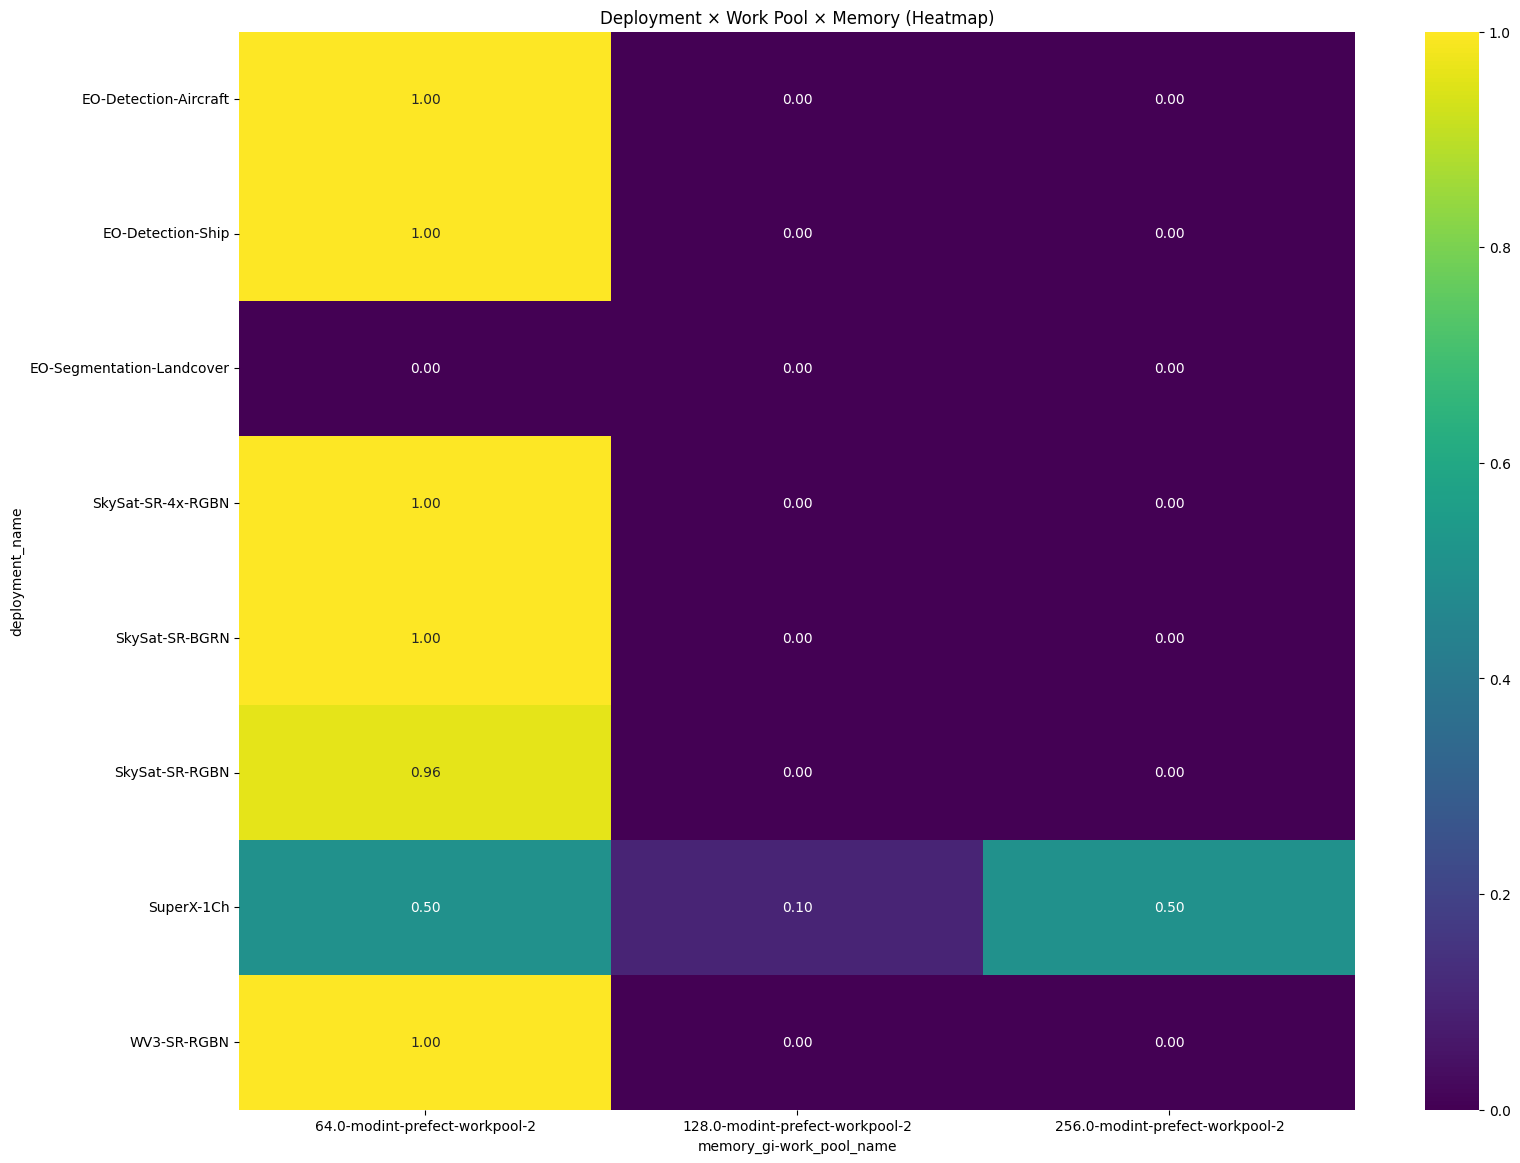

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = rate_area_dep_pool.copy()

pivot = df.pivot_table(
    values="success_rate",
    index="deployment_name",
    columns=["memory_gi","work_pool_name"],
    aggfunc="mean"
).fillna(0)

plt.figure(figsize=(18, 14))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="viridis"
)

plt.title("Deployment × Work Pool × Memory (Heatmap)")
plt.show()

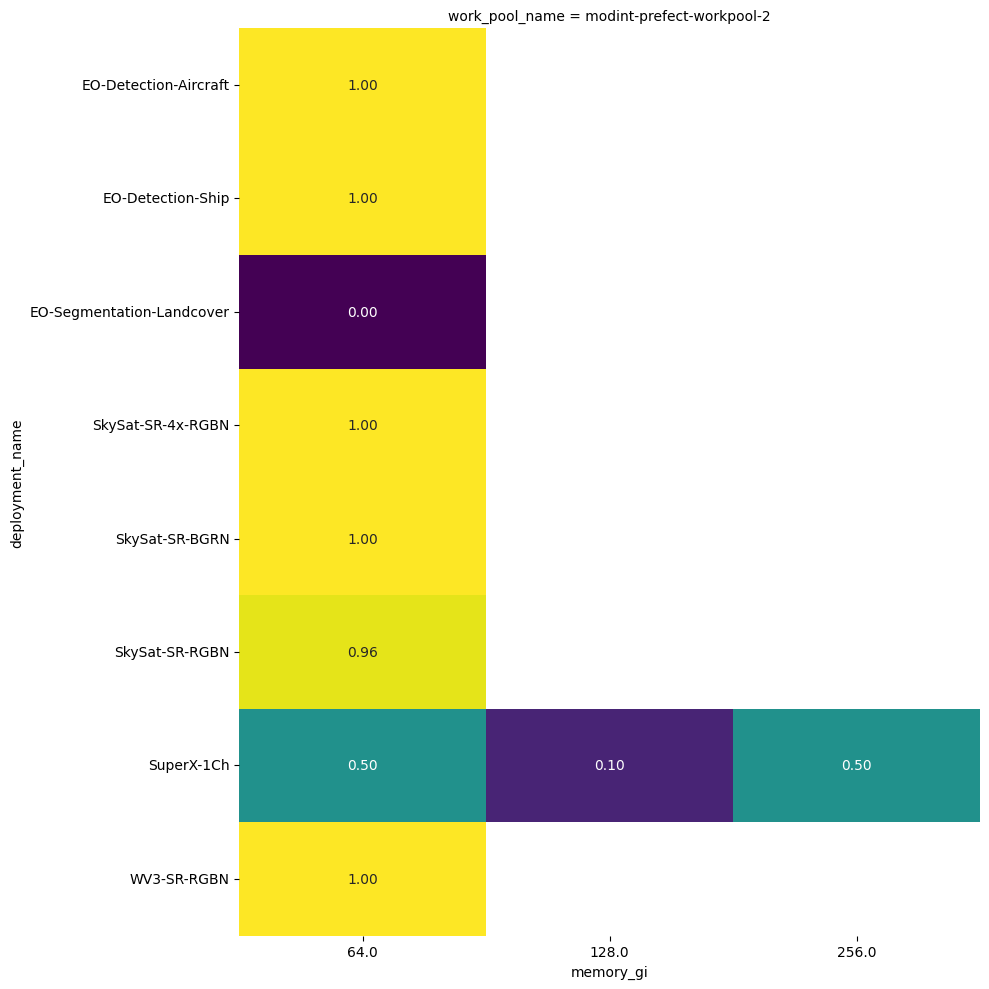

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

df = rate_area_dep_pool.copy()

g = sns.FacetGrid(
    df,
    col="work_pool_name",
    height=10,
    sharex=False,
    sharey=False
)

def draw(data, **kwargs):
    pivot = data.pivot_table(
        values="success_rate",
        index="deployment_name",
        columns="memory_gi"
    )
    sns.heatmap(pivot, cmap="viridis", annot=True, fmt=".2f", cbar=False)

g.map_dataframe(draw)
plt.show()

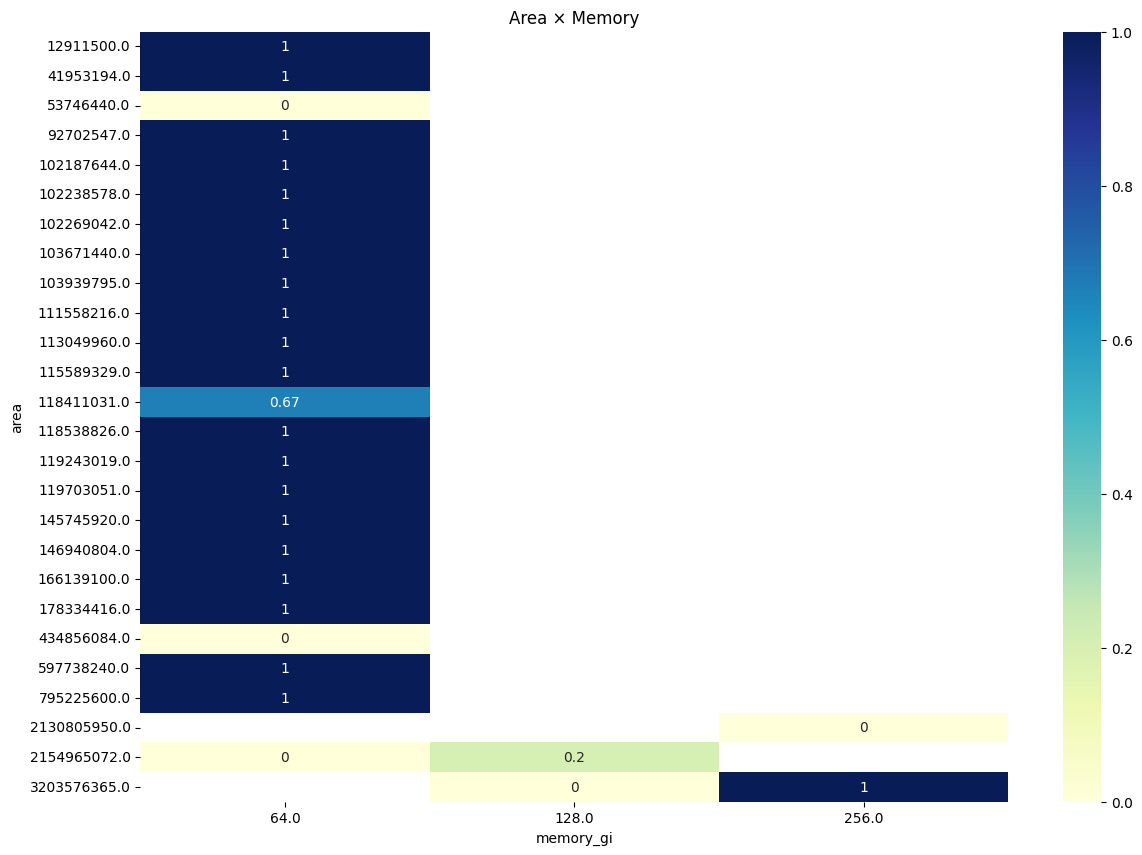

In [90]:
import numpy as np
import seaborn as sns

heat = runs.groupby(["area","memory_gi"])["state_type"] \
           .apply(lambda x: (x=="COMPLETED").mean()) \
           .reset_index().pivot(index="area", columns="memory_gi", values="state_type")

plt.figure(figsize=(14, 10))
sns.heatmap(heat, annot=True, cmap="YlGnBu")
plt.title("Area × Memory")
plt.show()

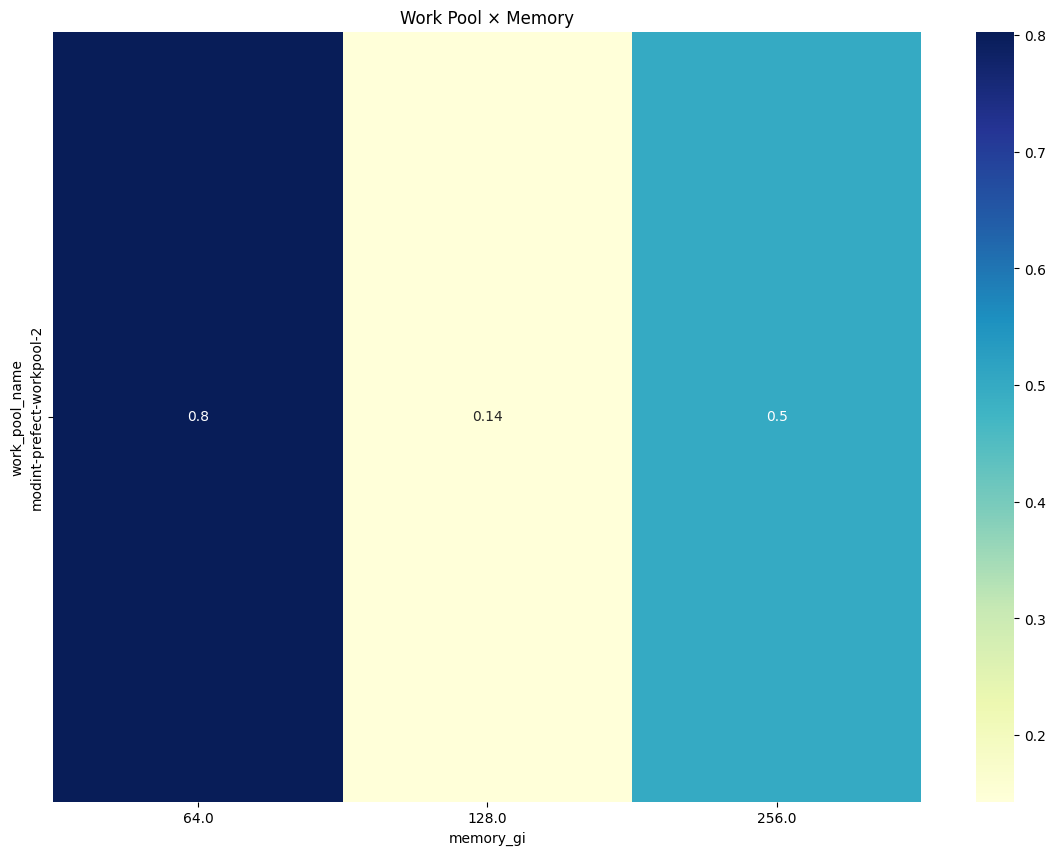

In [91]:
import numpy as np
import seaborn as sns

heat = runs.groupby(["work_pool_name","memory_gi"])["state_type"] \
           .apply(lambda x: (x=="COMPLETED").mean()) \
           .reset_index().pivot(index="work_pool_name", columns="memory_gi", values="state_type")

plt.figure(figsize=(14, 10))
sns.heatmap(heat, annot=True, cmap="YlGnBu")
plt.title("Work Pool × Memory")
plt.show()

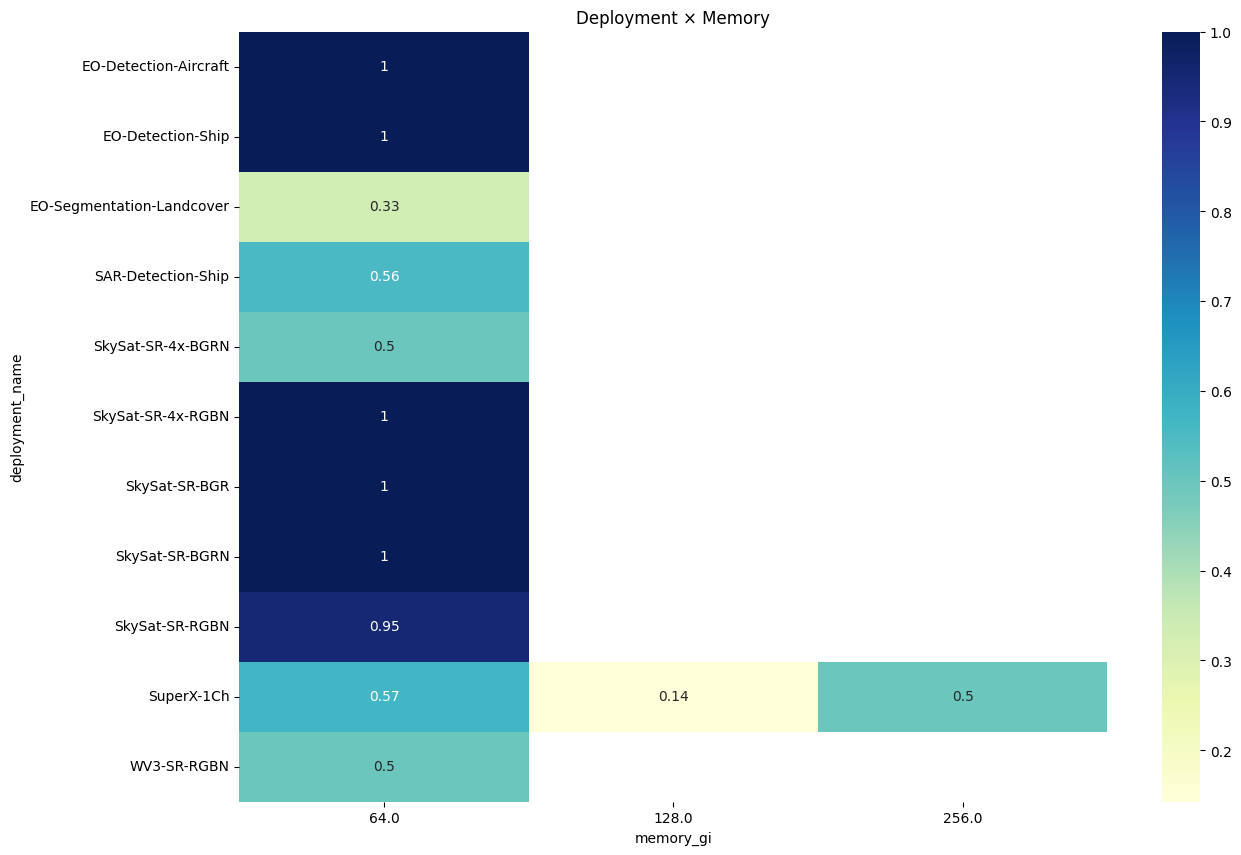

In [92]:
import numpy as np
import seaborn as sns

heat = runs.groupby(["deployment_name","memory_gi"])["state_type"] \
           .apply(lambda x: (x=="COMPLETED").mean()) \
           .reset_index().pivot(index="deployment_name", columns="memory_gi", values="state_type")

plt.figure(figsize=(14, 10))
sns.heatmap(heat, annot=True, cmap="YlGnBu")
plt.title("Deployment × Memory")
plt.show()